In [2]:
# from __future__ import print_function
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
from ipywidgets import *
from IPython.display import display
import IPython
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import numpy as np

from datetime import datetime
import talib
import pandas_ta as ta
# from talib.abstract import *
from math import *
from collections import OrderedDict
# import vectorbt as vbt    
import json
%matplotlib inline
# %matplotlib widget

matplotlib.rcParams.update({'font.size': 7, 'lines.linewidth': 0.7, 'figure.dpi': 100})


In [3]:
from statsmodels.tsa.seasonal import STL
import matplotlib.pyplot as plt
from datetime import datetime

In [4]:
# from pandas.plotting import register_matplotlib_converters

# from scipy import stats
# import statsmodels.api as sm
# from statsmodels.graphics.api import qqplot

# from statsmodels.tsa.stattools import acf, pacf
# from statsmodels.tsa.arima.model import ARIMA
# from statsmodels.tsa.statespace.sarimax import SARIMAX

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
# register_matplotlib_converters()
# from time import time

In [5]:
def perform_adf_test(series):
    result = adfuller(series)
    print('ADF Statistic: %f' % result[0])
    print('p-value: %f' % result[1])

In [6]:
df = pd.read_json(r'./freq-user-data/data/binance/BTC_USDT-1m.json').dropna()
df.columns = ['timestamp', 'open', 'high', 'low', 'close', 'volume']

df['date'] = pd.to_datetime(df['timestamp'], unit='ms', utc=False)
# df.index = df['time']
# df.set_index('time', drop=True, inplace=True)
df.set_index(pd.DatetimeIndex(df["date"]), inplace=True, drop=True)
# df = df[['time', 'symbol', 'source', 'resolution', 'open', 'high', 'low', 'close', 'volume']]
# df.to_csv (r'./data/binance/BTC_USDT-5m.csv', index = None)
# df.set_index('time')
df = df.sort_index()

In [7]:
ddf = df.copy().dropna()
dlen = len(ddf)
ddf['ret'] = ddf.close.diff()
ddf['pctchange'] = ddf.close.pct_change()
ddf['lret'] = np.log(ddf.close).diff()
ddf['lrange'] = ddf.high - ddf.low
ddf['lower'] = ddf.close * 0.99
ddf['upper'] = ddf.close * 1.01
# ddf['lrange'] = np.log(ddf.range).diff()

# ddf['lrange'] = ddf.range / ddf.close
# ddf['lrange'] = (ddf.close - ddf.low) / (ddf.high - ddf.low)

In [8]:
# ddf
# dlen
floor(pi)

3

In [11]:
num_lags = 30

sl_n2= IntSlider(description="n2", min=0, max=floor(log(dlen, 2.0)), step=1, value=9)
sl_w = IntSlider(description="w", min=0, max=floor(dlen/pow(2,9)), step=1, value=5)
def update_sl_w_range(*args):
    wsize = pow(2,sl_n2.value)
    sl_w.max = floor(dlen/wsize)*2 
sl_n2.observe(update_sl_w_range, 'value')


# wdg_lags = IntSlider(description="lags", min=1, max=50, step=1, value=20)

# wdg_ma = widgets.IntSlider(value=50,description='ma:',disabled=False)
# wdg_stn = widgets.IntSlider(value=50,description='stn:',disabled=False)


wdg_nperiod = widgets.IntSlider(value=5, min=1, max=100,description='per:',disabled=False)
wdg_nseasonal = widgets.IntSlider(value=7, min=1, max=50, step=2, description='seas:',disabled=False)
wdg_ntrend = widgets.IntSlider(value=7, min=1, max=800, step=20, description='trend:',disabled=False)
wdg_nlow_pass = widgets.IntSlider(value=3, min=1, max=150, step=2, description='lpass:',disabled=False)

wdg_ntrain = widgets.FloatSlider(value=0.5, min=0.1, max=1., step=0.005, description='train:',disabled=False)

# wdg_llag = widgets.IntSlider(value=60, min=-800, max=800, step=10, description='llag:',disabled=False)
# wdg_ulag = widgets.IntSlider(value=60, min=-800, max=800, step=10, description='ulag:',disabled=False)

ui = widgets.VBox([
    # widgets.HBox([wdg_lags, wdg_ma, wdg_stn]),
    widgets.HBox([sl_n2, sl_w]),
    widgets.HBox([wdg_nperiod, wdg_nseasonal, wdg_ntrend, wdg_nlow_pass]),
    wdg_ntrain
    # widgets.HBox([wdg_llag, wdg_ulag]),
    # widgets.HBox([wdg_nlow_pass])
])

wst = wed = wsz = wdf = norser = False
# , lags, ma, stn
# , llag, ulag
def printer(w2log, w, nperiod, nseasonal,ntrend, nlow_pass, ntrain):

    with open(f'./strat-params-stl.json', "w") as f: f.write(json.dumps({k: v.value for k, v in dvals.items()})) 

    # ddf['lclose'] = ddf.lower.shift(llag).rolling(abs(llag)).min()
    # ddf['uclose'] = ddf.upper.shift(ulag).rolling(abs(ulag)).max()
    

    global wst, wed, wsz, wdf, norser
    wsz = floor(pow(2,w2log))
    wst = floor(w * wsz / 2)
    wed = floor(wst + wsz)
    
    # ddf['ma'] = ddf.close.ewm(span=ma,min_periods=0,adjust=False,ignore_na=False).mean()
    # ddf['stdr'] = ddf.close.rolling(stn).std()

    wdf = ddf.iloc[wst:wed,:].copy()
    wlen = len(wdf)
    wtrdf = wdf.iloc[:floor(ntrain * wlen)]

    stl = STL(wtrdf.close, period=nperiod, seasonal=nseasonal, trend=ntrend, low_pass=nlow_pass)
    result = stl.fit()
    seasonal, trend, resid = result.seasonal, result.trend, result.resid

    # wdf['dtr'] = (wdf.close - wdf.ma) / wdf.stdr
    # wdf['dtr'] = (wdf.close - wdf.ma)/wdf.ma

    # norser = wdf.dtr
    # acf_vals = acf(norser,fft=True)
    # pacf_vals = pacf(norser)

    plt.close("all")
    fig = plt.figure(constrained_layout=True,figsize=(12,4))
    gs0 = fig.add_gridspec(5, 1, height_ratios=[2,1,1,1,2])

    # gs00 = gs0[0,0].subgridspec(3, 1, height_ratios=[3,1,1])

    ax00 = fig.add_subplot(gs0[0,0])
    ax01 = fig.add_subplot(gs0[1,0], sharex=ax00)
    ax02 = fig.add_subplot(gs0[2,0], sharex=ax00)
    ax03 = fig.add_subplot(gs0[3,0], sharex=ax00)


    gs04 = gs0[4,0].subgridspec(1, 2)
    ax401 = fig.add_subplot(gs04[0,0])
    ax402 = fig.add_subplot(gs04[0,1])

    ax00.plot(wdf['close'])
    ax00.fill_between(wdf.index, wdf.lower, wdf.upper, alpha=0.15)
    # ax00.plot(wdf['lclose'])
    # ax00.plot(wdf['uclose'])

    ax01.plot(trend)
    ax02.plot(seasonal)
    ax02.axhline()
    ax03.plot(resid)
    ax03.axhline()

    # ax2.plot(norser)
    # ax2.axhline()


    # plot_pacf(resid, ax=ax402)
    # plot_acf(resid, ax=ax401)

    # ax301.bar(range(lags), acf_vals[:lags])
    # ax301.axhline()
    # ax301.axhline(y=-0.2, linestyle='--')
    # ax301.axhline(y=0.2, linestyle='--')
    # ax302.bar(range(lags), pacf_vals[:lags])
    # ax302.axhline()
    # ax302.axhline(y=-0.2, linestyle='--')
    # ax302.axhline(y=0.2, linestyle='--')

    # ax101 = fig.add_subplot(gs01[0,0])
    # ax102 = fig.add_subplot(gs01[1,0])
    # ax103 = fig.add_subplot(gs01[2,0])
    # ax104 = fig.add_subplot(gs01[3,0])

    # fig, (ax1, ax2) = plt.subplots(2, 1, sharex='col', figsize=(12,2))
    

#     wma1 = wdf['ma1']; wma2 = ma2[wdf.index]; wma3 = ma3[wdf.index];
    
    
    
    plt.show()
    perform_adf_test(resid)
    

# with open('./strat-params-stl.json') as f: 
#     js = json.loads(f.read())
#     sl_n2.value=js["w2log"]; sl_w.value=js["w"]; wdg_lags.value = js["lags"]; wdg_ma.value = js["ma"]; wdg_stn.value = js["stn"];

dvals = {"w2log":sl_n2, "w":sl_w, 
    "nperiod": wdg_nperiod, "nseasonal": wdg_nseasonal, "ntrend": wdg_ntrend, "nlow_pass": wdg_nlow_pass, "ntrain": wdg_ntrain,
    # "llag": wdg_llag, "ulag": wdg_ulag
    # "lags": wdg_lags, "ma": wdg_ma, "stn": wdg_stn
    }

with open('./strat-params-stl.json') as f: 
    js = json.loads(f.read());
    for k, v in dvals.items(): 
        if k in js: v.value=js[k] ;


out = widgets.interactive_output(printer, dvals)

display(ui, out)


Output()

In [21]:
ntrain = floor(len(norser)/3*2)
norser_train = norser[:ntrain]
model = ARIMA(norser_train, order=(1,0,0))
model_fit = model.fit()
print(model_fit.summary())

/Users/johnsmith/opt/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency 5T will be used.
  warnings.warn('No frequency information was'
/Users/johnsmith/opt/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency 5T will be used.
  warnings.warn('No frequency information was'
/Users/johnsmith/opt/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency 5T will be used.
  warnings.warn('No frequency information was'


                               SARIMAX Results                                
Dep. Variable:                    dtr   No. Observations:                  153
Model:                 ARIMA(1, 0, 0)   Log Likelihood                 793.455
Date:                Wed, 14 Jul 2021   AIC                          -1580.911
Time:                        17:07:38   BIC                          -1571.819
Sample:                    07-13-2021   HQIC                         -1577.218
                         - 07-13-2021                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0005      0.001     -0.536      0.592      -0.002       0.001
ar.L1          0.8713      0.036     24.042      0.000       0.800       0.942
sigma2      1.813e-06   1.72e-07     10.556      0.0

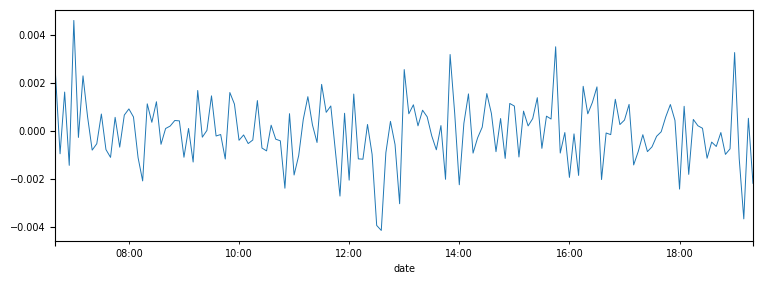

In [22]:
fig = plt.figure(figsize=(9,3))
ax = fig.add_subplot(111)
ax = model_fit.resid.plot(ax=ax);

In [23]:
resid = model_fit.resid
# stats.normaltest(resid)
k2, p = stats.normaltest(resid)
alpha = 1e-3
print("p = {:g}".format(p))
p = 8.4713e-19
if p < alpha:  # null hypothesis: x comes from a normal distribution
    print("The null hypothesis can be rejected")
else:
    print("The null hypothesis cannot be rejected")


p = 0.0674785
The null hypothesis can be rejected


In [24]:
# resid
len(resid)

153

/Users/johnsmith/opt/anaconda3/envs/py38/lib/python3.8/site-packages/statsmodels/graphics/gofplots.py:993: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "bo" (-> marker='o'). The keyword argument will take precedence.
  ax.plot(x, y, fmt, **plot_style)


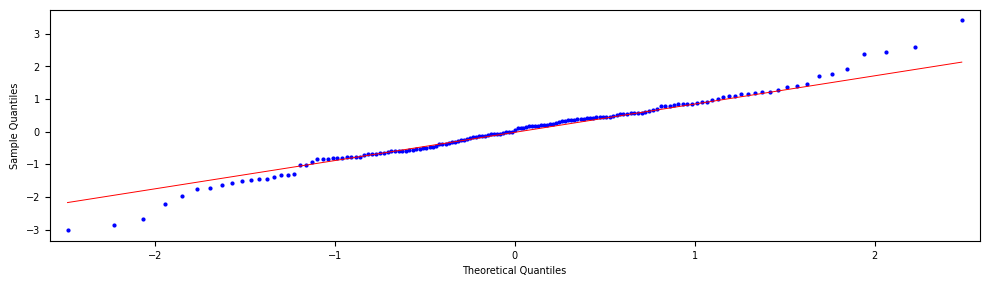

In [25]:
fig = plt.figure(figsize=(12,3))
ax = fig.add_subplot(111)
fig = qqplot(resid, line='q', ax=ax, fit=True, markersize=2)

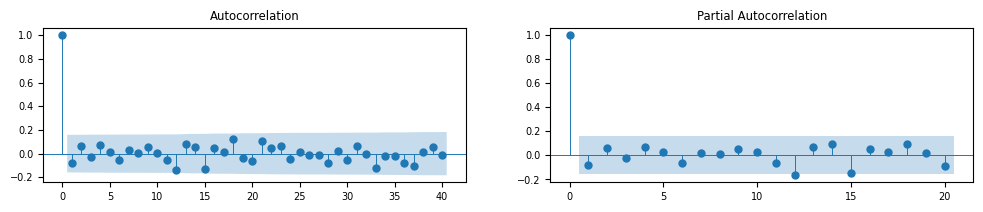

In [26]:
fig = plt.figure(figsize=(12,2))
ax1 = fig.add_subplot(121)
fig = sm.graphics.tsa.plot_acf(resid.values.squeeze(), lags=40, ax=ax1)
ax2 = fig.add_subplot(122)
fig = sm.graphics.tsa.plot_pacf(resid, lags=20, ax=ax2)

In [27]:
prediction_info = model_fit.forecast(5)

predictions = prediction_info[0]
lower_bound = prediction_info[2][:,0]
# upper_bound = prediction_info[2][:,1]

IndexError: invalid index to scalar variable.

In [138]:
prediction_info

2019-01-06 15:05:00    1.209967
2019-01-06 15:10:00    0.829513
2019-01-06 15:15:00    0.577446
2019-01-06 15:20:00    0.410442
2019-01-06 15:25:00    0.299795
Freq: 5T, Name: predicted_mean, dtype: float64